Elias mezine
# projet sberbank-russian-housing-market Kaggle :
https://www.kaggle.com/c/sberbank-russian-housing-market/overview
<p> Le but de ce projet est de prédire le prix des maisons <p>

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from math import isnan
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
 train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(157), object(16)
memory usage: 67.9+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Columns: 291 entries, id to market_count_5000
dtypes: float64(116), int64(159), object(16)
memory usage: 17.0+ MB


In [7]:
[col for col in train.columns if col not in test.columns]
# toutes les colonnes présentes dans train le sont aussi dans test sauf la colonne cible price_doc

['price_doc']

In [8]:
# en Mai 2017, 1€ vaut entre 62 et 64 roubles
train.price_doc.describe()/63

count    4.836667e+02
mean     1.130641e+05
std      7.587478e+04
min      1.587302e+03
25%      7.523813e+04
50%      9.959383e+04
75%      1.317460e+05
max      1.763668e+06
Name: price_doc, dtype: float64

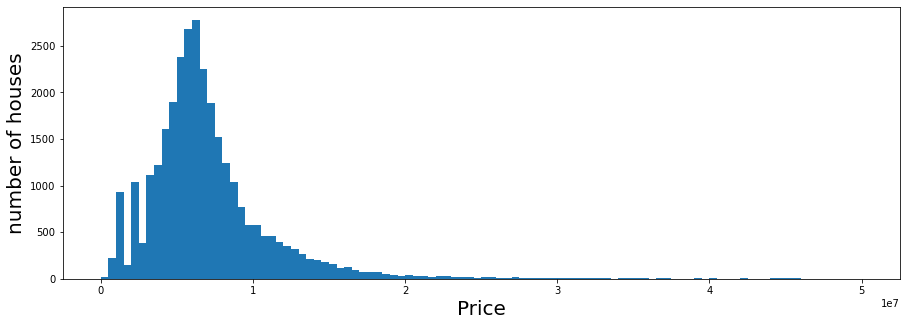

In [9]:
plt.figure(figsize= (15,5))
plt.hist(train['price_doc'], bins = 100, range=(0,5*10**7))
plt.xlabel('Price', fontsize=20)
plt.ylabel('number of houses', fontsize=20)
plt.show()

In [10]:
objCols = lambda df : list(df.select_dtypes(include = 'object').columns)
trainObjCols = objCols(train)
trainObjCols

['timestamp',
 'product_type',
 'sub_area',
 'culture_objects_top_25',
 'thermal_power_plant_raion',
 'incineration_raion',
 'oil_chemistry_raion',
 'radiation_raion',
 'railroad_terminal_raion',
 'big_market_raion',
 'nuclear_reactor_raion',
 'detention_facility_raion',
 'water_1line',
 'big_road1_1line',
 'railroad_1line',
 'ecology']

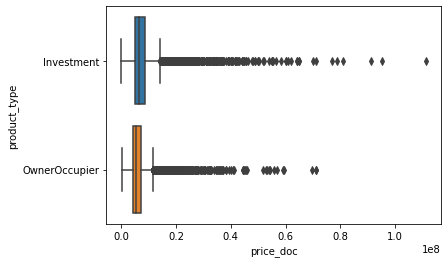

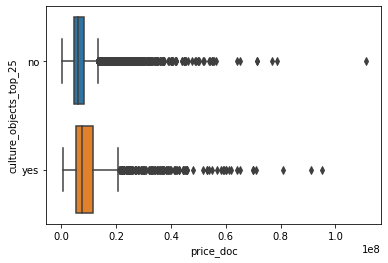

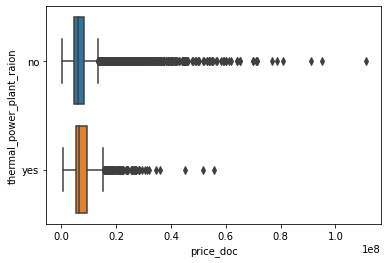

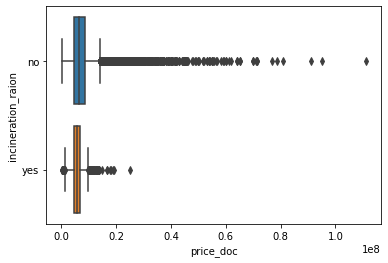

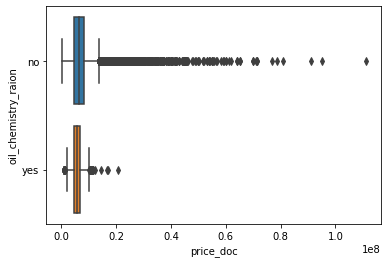

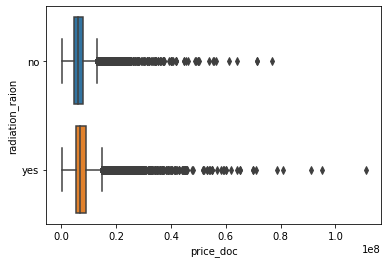

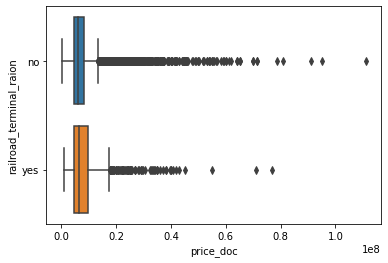

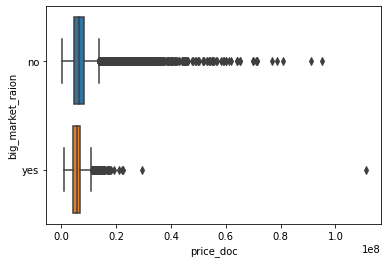

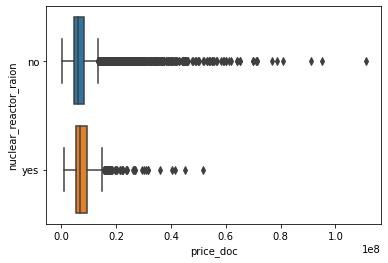

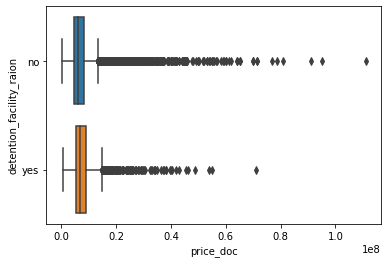

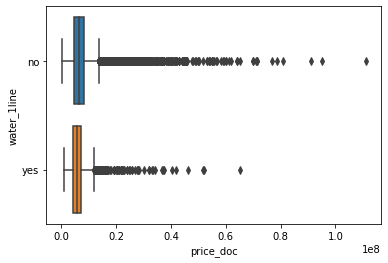

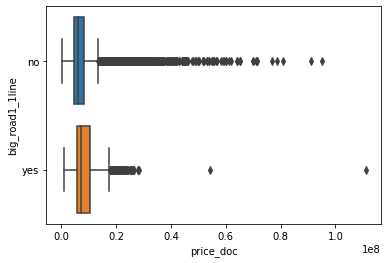

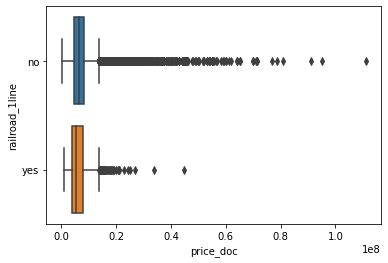

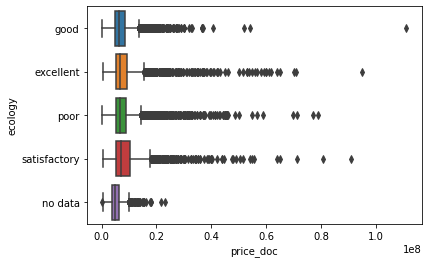

In [11]:
# on regarde d'un peu plus près les colonnes objet
trainObjCols.remove('timestamp')
trainObjCols.remove('sub_area')
for objCol in trainObjCols:
    sns.boxplot(x="price_doc",y=objCol, data=train)
    plt.show()

In [12]:
# Pour ne perdre aucune donnée, on converti les colonnes object en numérique (ne fonctionne pas pour le modèle LGB)
# on définit une fonction qui donne les valeurs sans doublons que peut prendre la colonne qu'on lui passe en argument
unique = lambda df,col : df[col].unique()
# pour chaque colonne, on remplace les valeurs de type string par les index des valeurs renvoyées par la fonction précédente
replaceStr = lambda df :[[df[objCol].replace(unique(df,objCol)[idxCol],idxCol,inplace=True) for idxCol in range(len(unique(df,objCol)))] for objCol in objCols(df)]
replaceStr(train)
replaceStr(test)
# on peut maintenant remplacer le type des colonnes object par le type int
objToNum = lambda df : [pd.to_numeric(df[objCol]) for objCol in objCols(df)]
objToNum(train)
objToNum(test)

[]

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30471 entries, 0 to 30470
Columns: 292 entries, id to price_doc
dtypes: float64(119), int64(173)
memory usage: 67.9 MB


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Columns: 291 entries, id to market_count_5000
dtypes: float64(117), int64(174)
memory usage: 17.0 MB


In [15]:
train['build_year'] = train['build_year'].replace({20052009: 2007, 0: 2000, 4965: 1957})
train['build_year'] = train['build_year'].replace({1: 2001, 2: 2002, 3: 2003})
train['build_year'] = train['build_year'].replace({71: 1971, 20: 1920, 215: 2015})

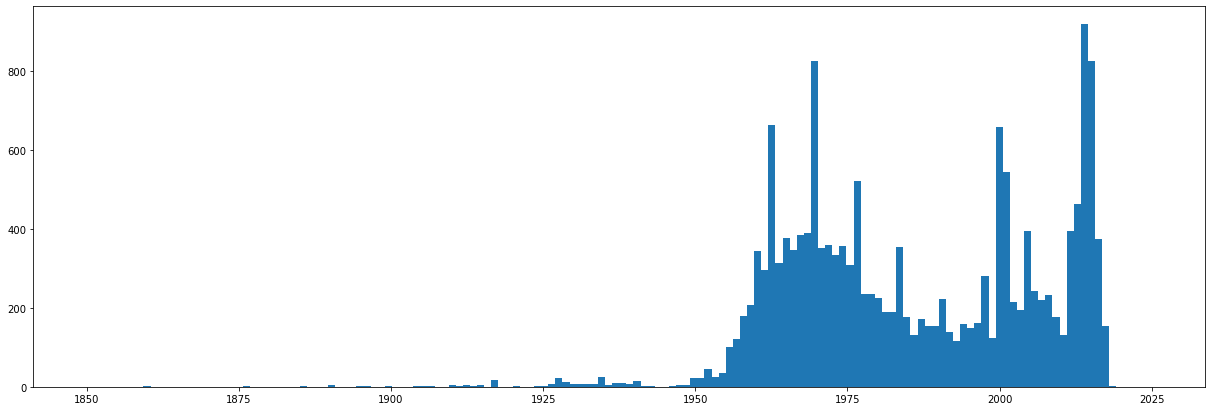

In [16]:
plt.figure(figsize=(21, 7))
plt.hist(train['build_year'], bins=150, range=(1850,2025))
plt.show()

In [17]:
# regardons le taux de valeurs manquantes dans chacune de ces colonnes
def missing_hist(df) :
    df_na = (df.isnull().sum() / df.shape[0]) * 100
    df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)

    f, ax = plt.subplots(figsize=(24, 16))
    plt.xticks(rotation='90')
    sns.barplot(x=df_na.index, y=df_na)
    ax.set(title='Pourcentage valeurs manquantes par colonne dans df', ylabel='% manquant')
    plt.subplots_adjust(top = 0.95, bottom = 0.5)
    plt.show()

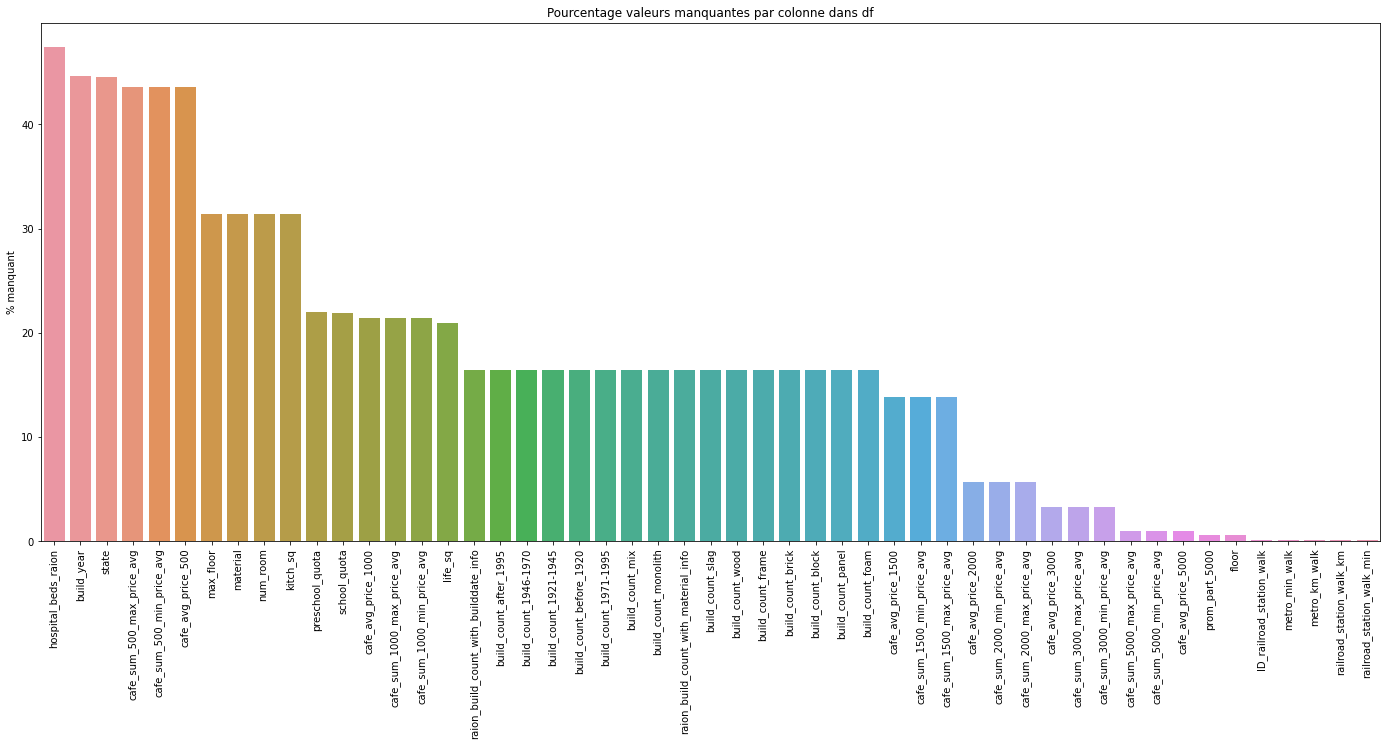

In [18]:
# Visualisation des valeurs manquantes dans train:
# train.isna().sum().loc[lambda x : x>0]*100/train.shape[0]
missing_hist(train)

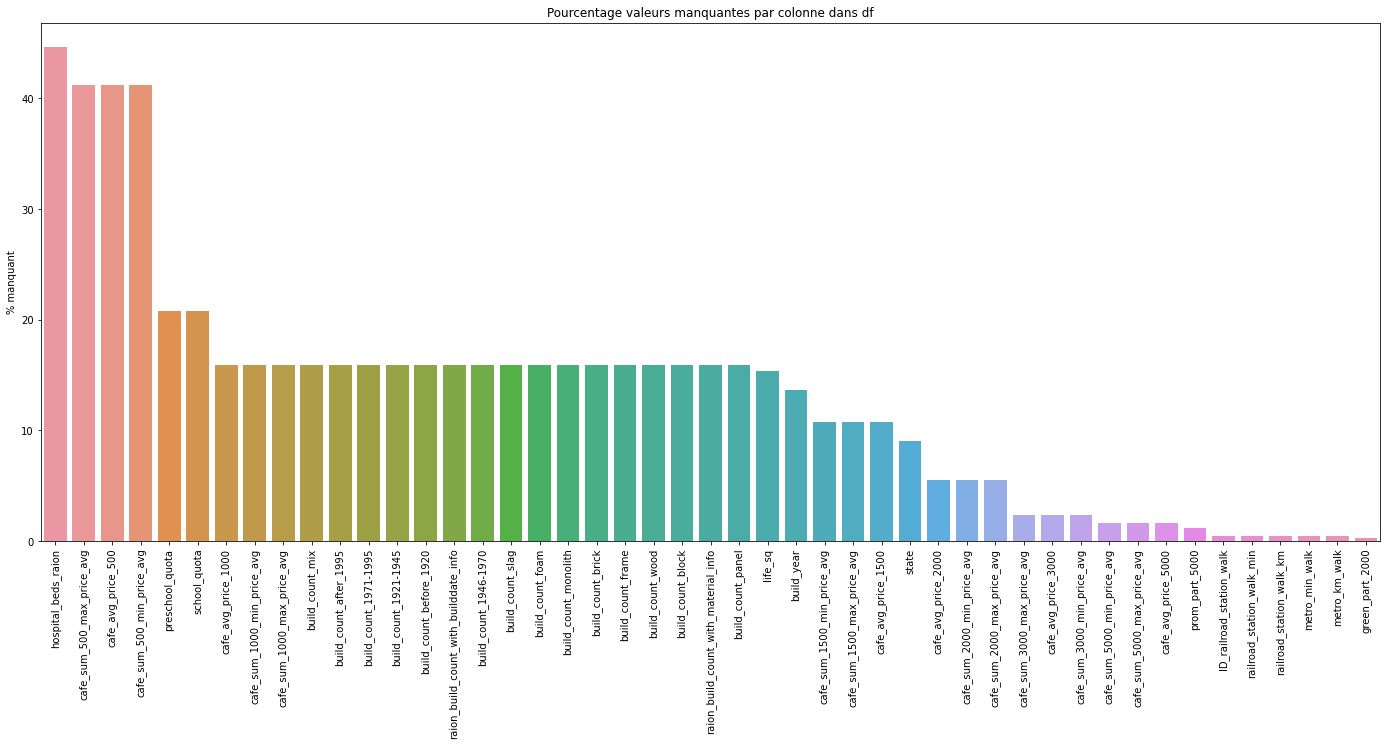

In [19]:
# Visualisation des valeurs manquantes dans test:
missing_hist(test)

In [20]:
train.loc[train.max_floor==0,'max_floor'] = np.nan
train.loc[train.floor==0,'floor'] = np.nan
train.loc[train.floor>train.max_floor,'max_floor'] = np.nan
train.loc[train.num_room==0,'num_room'] = np.nan
train.loc[train.life_sq>train.full_sq,'full_sq'] = np.nan
train.loc[train.full_sq<5,'full_sq'] = np.nan
train.loc[train.life_sq<5,'life_sq'] = np.nan
train.loc[train.kitch_sq>train.life_sq,'kitch_sq'] = np.nan

In [21]:
# pour chaque colonne avec des valeurs manquantes, on trace le nuage de point
# avec la colonne price_doc pour chercher les colonnes corrélées
def nuages(features) :
    cible = train['price_doc']
    nb_col = len(features)
    fig = plt.figure(figsize=(15,int(nb_col*3.5)))
    for i in range(nb_col) :
        ax = fig.add_subplot((nb_col//2)+1,2,i+1)
        col = features[i]
        ax.scatter(train[col],cible)
        ax.set_xlabel(col, color='darkgreen')
        ax.set_ylabel('price_doc', color='darkgreen')
        ax.set_title('price_doc en fonction de ' + col)
    plt.show()

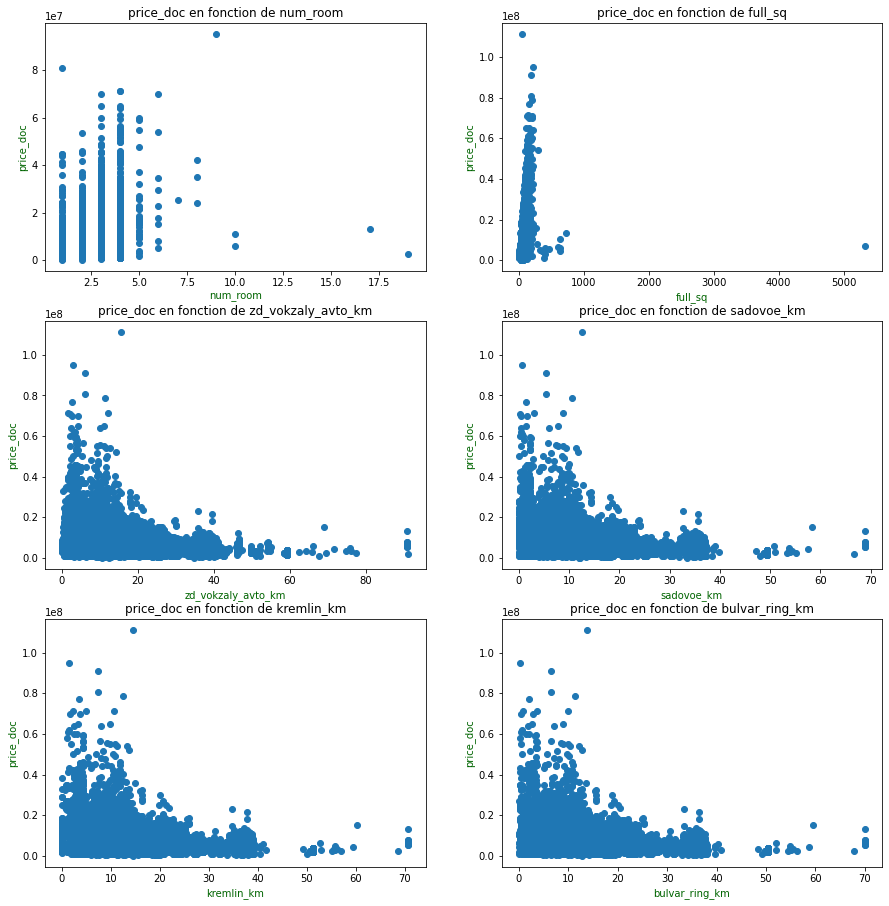

In [22]:
# on calcule les corrélations des colonnes avec la colonne cible et on classe les colonnes dans l'ordre décroissant
best_corr = list(train.corr()['price_doc'].abs().sort_values(ascending=False).index)
nuages(best_corr[1:3]+best_corr[6:10])

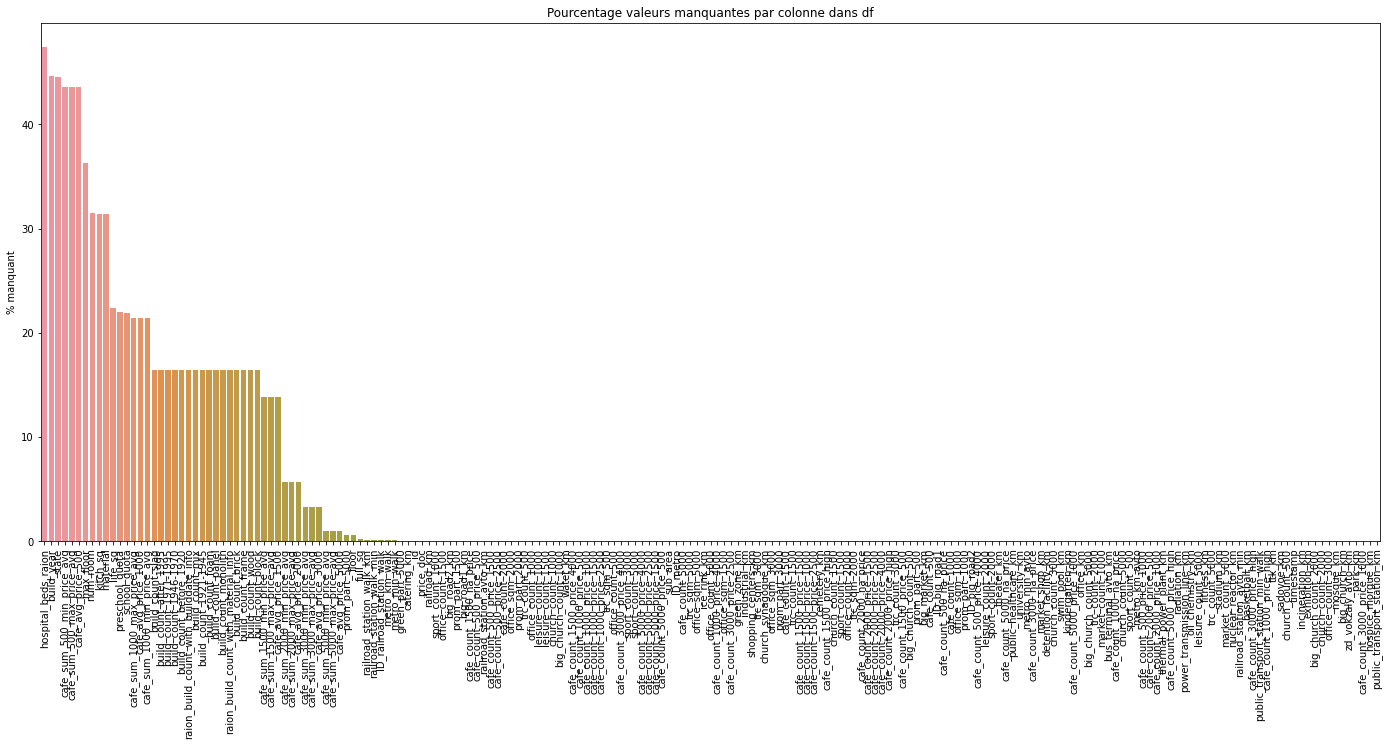

In [23]:
# On remarque qu'il y a bcp de valeurs aberrantes
# suppression des valeurs aberrantes
for col in train.columns :
    train[col] = train[col][train[col].between(train[col].quantile(.00001), train[col].quantile(.9999))]

missing_hist(train)

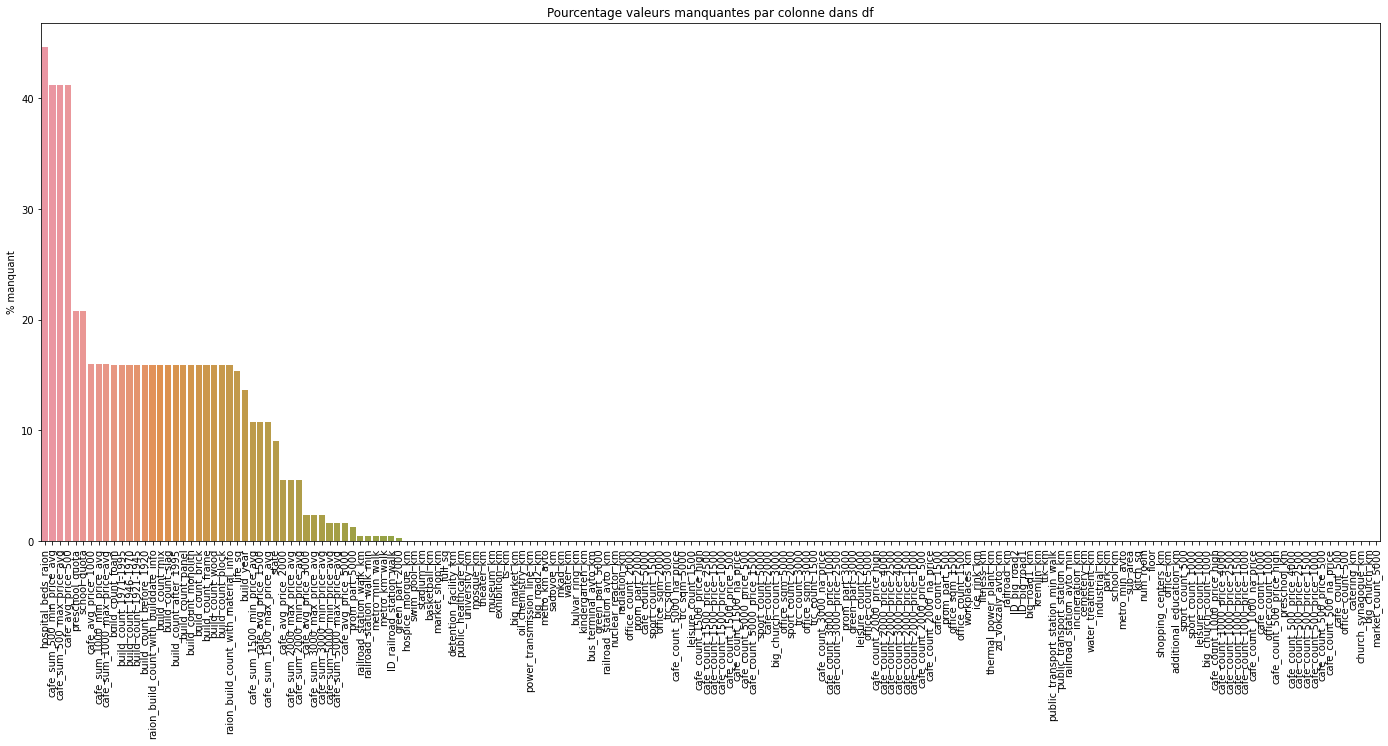

In [24]:
# On remarque qu'il y a bcp de valeurs aberrantes
# suppression des valeurs aberrantes
for col in test.columns.drop('id') :
    test[col] = test[col][test[col].between(test[col].quantile(.00001), test[col].quantile(.9999))]
    
missing_hist(test)

In [25]:
train_test = pd.concat([train,test], ignore_index=True)

train_columns_with_nans = list(train.columns[train.isnull().any()])
test_columns_with_nans = list(test.columns[test.isnull().any()])
train_test_columns_with_nans = list(set(train_columns_with_nans+test_columns_with_nans))

# On enregistre dans des listes les index des valeurs manquantes par colonnes pour les dataSet train et test pour pouvoir
# prédires les valeurs de certaines colonnes plus tard
idx_nan_train_columns_with_nans = [[idx for idx in range(train.shape[0]) if isnan(train[col][idx])] for col in train_columns_with_nans]

dict_idx_nan_train_columns_with_nans = dict()
for col in train_columns_with_nans :
    dict_idx_nan_train_columns_with_nans[col] = [idx for idx in range(train.shape[0]) if isnan(train[col][idx])]
# idx_nan_test_columns_with_nans = [[idx for idx in range(test.shape[0]) if (col!='price_doc' and isnan(test[col][idx]))] for col in train_test_columns_with_nans]

# On enregistre les index des valeurs non manquantes des colonnes possèdant des valeurs manquantes
# dans la concaténation des dataSets train et test pour les utiliser pour la prédiction des valeurs manquantes de ces colonnes
idx_not_nan_train_test_columns_with_nans = [[idx for idx in range(train_test.shape[0]) if not isnan(train_test[col][idx])] for col in train_test_columns_with_nans]

dict_idx_not_nan_train_test_columns_with_nans = dict()
for col in train_test_columns_with_nans :
    dict_idx_not_nan_train_test_columns_with_nans[col] = [idx for idx in range(train_test.shape[0]) if not isnan(train_test[col][idx])]

In [26]:
# On remplace toutes les valeurs nulles par la moyenne pour pouvoir appliquer le modèle
train=train.fillna(train.mean())
test = test.fillna(test.mean())

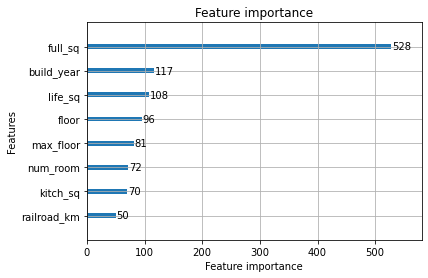

In [27]:
X=train.drop(['id', 'price_doc', 'timestamp'],axis=1)
y=train['price_doc']

LGBmodel = LGBMRegressor(num_leaves=32, learning_rate=0.1, max_depth=5, n_estimators=200)
LGBmodel.fit(X,y)
lgb.plot_importance(LGBmodel, max_num_features=8)

best_features = list(pd.Series(LGBmodel.feature_importances_, index=X.columns).nlargest(8).index)
best_features.append('material')
best_features.append('product_type')
best_features_with_nans = [feature for feature in best_features if feature in train_columns_with_nans]

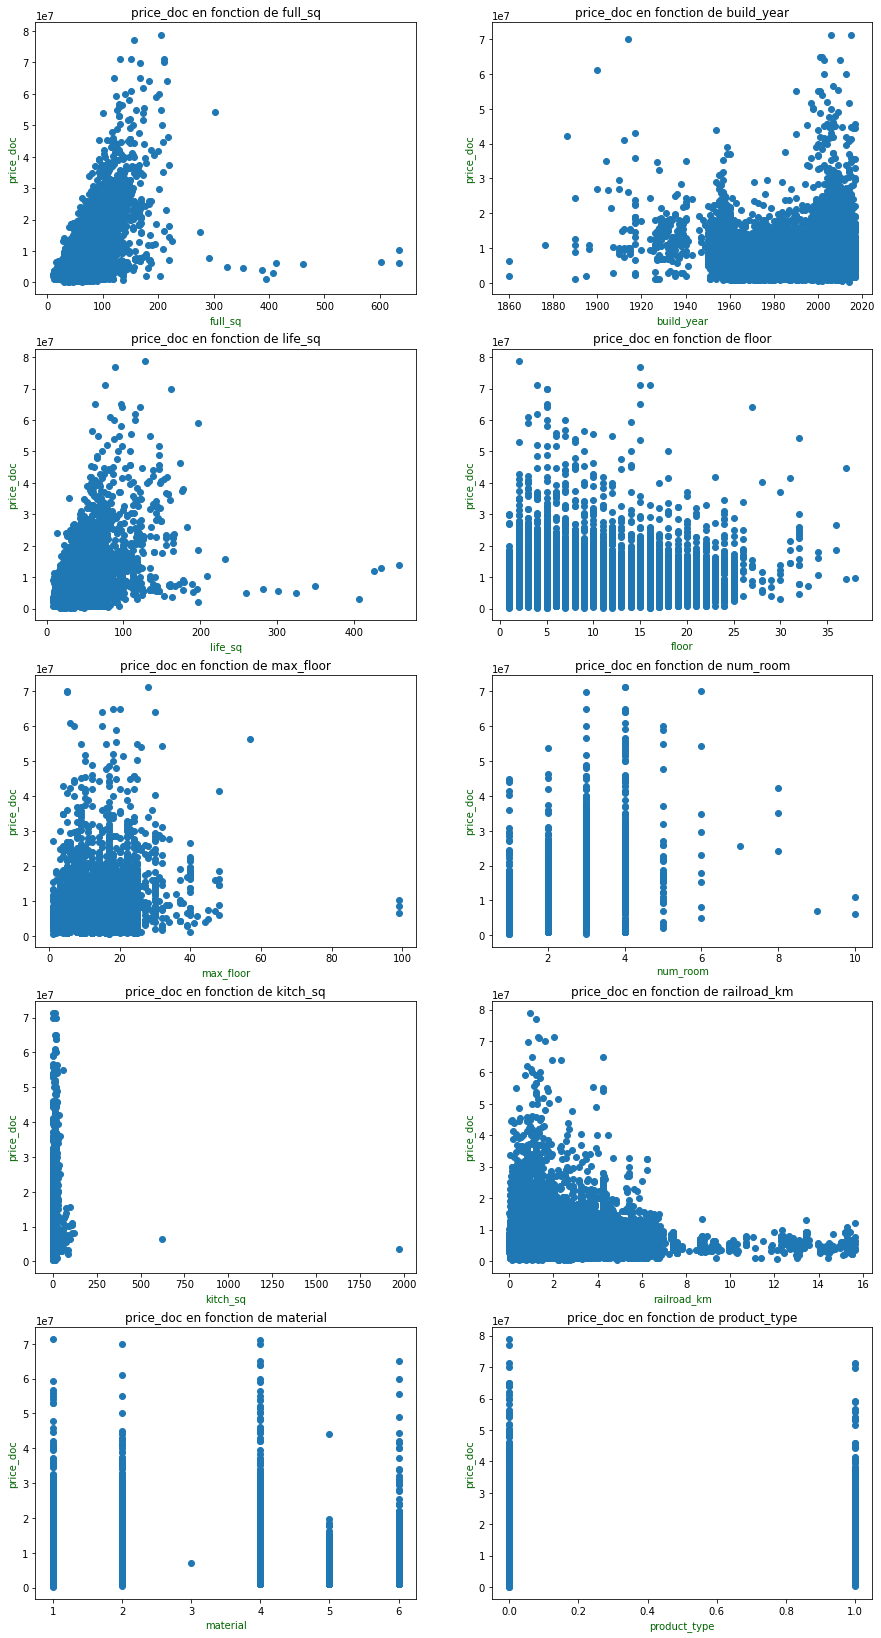

In [28]:
idx_nan_train_best_features = [dict_idx_nan_train_columns_with_nans[col] for col in best_features_with_nans if col in train_columns_with_nans]
idx_not_nan_train_test_best_features = [dict_idx_not_nan_train_test_columns_with_nans[col] for col in best_features_with_nans if col in train_test_columns_with_nans]

# On remplace par des valeurs nulles les valeurs initialement nulles des colonnes de best_features 
# qu'ont avait remplacé par la moyenne pour pouvoir en faire l'analyse.
# Ensuite, on les remplacera par les valeurs prédites par le modèle
for i_col in range(len(best_features_with_nans)) :
    train.loc[idx_nan_train_best_features[i_col],best_features_with_nans[i_col]] = np.nan
    
nuages(best_features)
best_features = best_features_with_nans

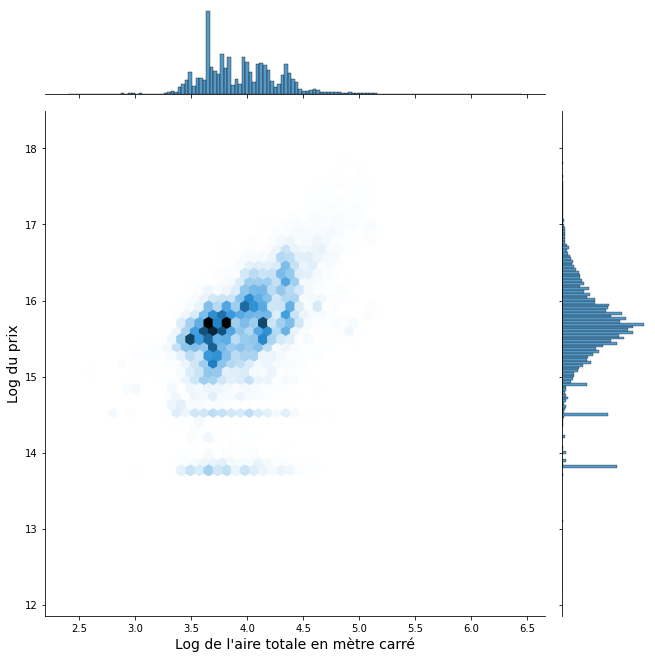

In [29]:
sns.jointplot(x=np.log1p(train.full_sq.values), y=np.log1p(train.price_doc.values), data=train, kind='hex', height=9)
plt.ylabel('Log du prix', fontsize=14)
plt.xlabel("Log de l'aire totale en mètre carré", fontsize=14)
plt.show()

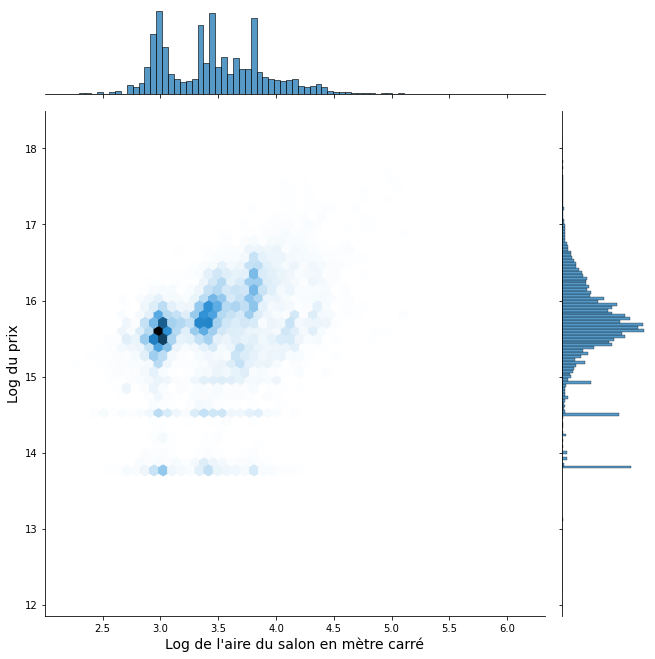

In [30]:
sns.jointplot(x=np.log1p(train.life_sq.values), y=np.log1p(train.price_doc.values), data=train, kind='hex', height=9)
plt.ylabel('Log du prix', fontsize=14)
plt.xlabel("Log de l'aire du salon en mètre carré", fontsize=14)
plt.show()

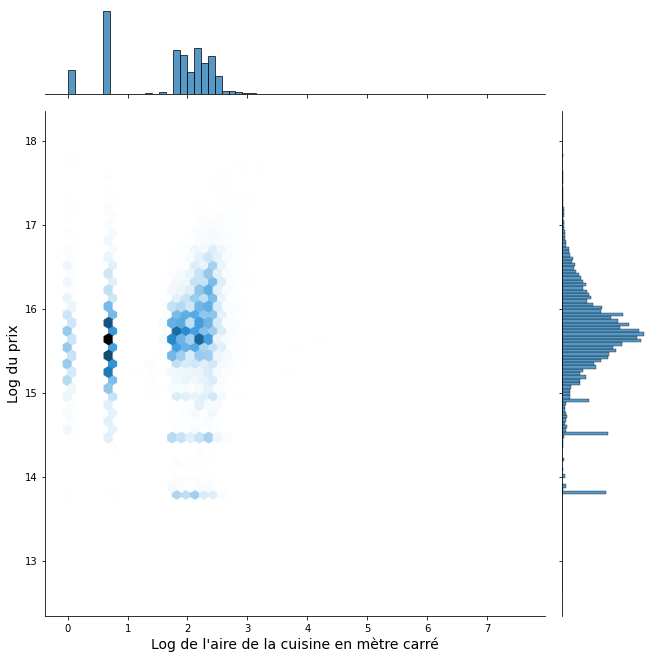

In [31]:
sns.jointplot(x=np.log1p(train.kitch_sq.values), y=np.log1p(train.price_doc.values), data=train, kind='hex', height=9)
plt.ylabel('Log du prix', fontsize=14)
plt.xlabel("Log de l'aire de la cuisine en mètre carré", fontsize=14)
plt.show()

(0.0, 50000000.0)

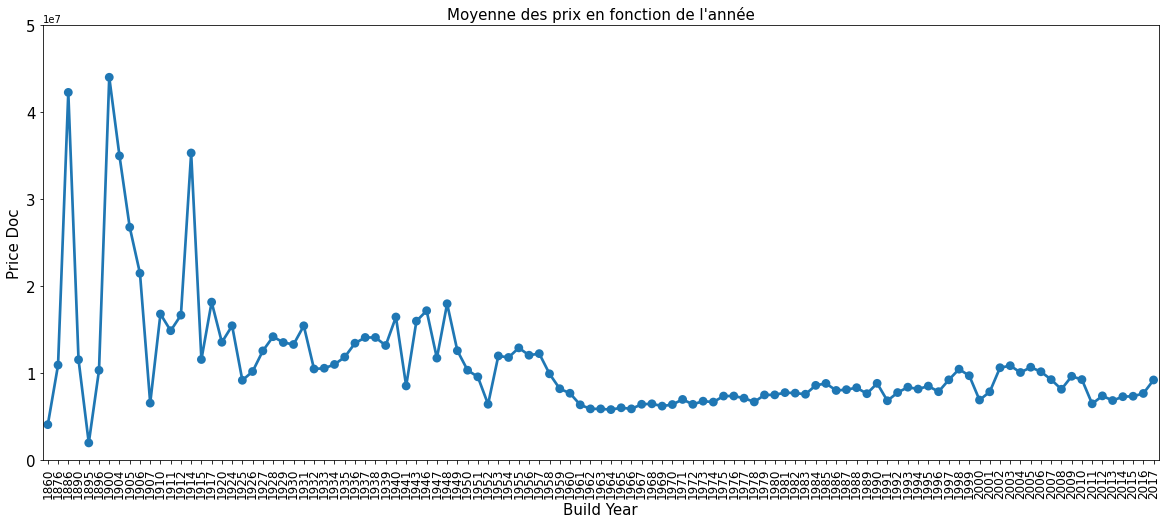

In [32]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
trainBuildAndPrice = train[['price_doc','build_year']].dropna()
trainBuildAndPrice["build_year"] = trainBuildAndPrice["build_year"].map(lambda x:str(x).split(".")[0])
trainBuildAndPrice = trainBuildAndPrice.groupby(["build_year"])["price_doc"].mean().to_frame().reset_index()
sns.pointplot(x=trainBuildAndPrice["build_year"], y=trainBuildAndPrice["price_doc"], data=trainBuildAndPrice, join=True,ax=ax)
# ax.set(xlabel='Build Year', ylabel='Price Doc', title="Moyenne des prix en fonction de l'année")
ax.set_xlabel('Build Year', fontsize = 15)
ax.set_ylabel('Price Doc', fontsize = 15)
ax.set_title("Moyenne des prix en fonction de l'année", fontsize = 15)
plt.xticks(rotation=90, size=12)
plt.yticks(size =15)
plt.ylim([0,5*10**7])

[Text(0, 0.5, 'Price Doc'),
 Text(0.5, 0, 'Max Floor'),
 Text(0.5, 1.0, 'Max Floor Vs Price Doc')]

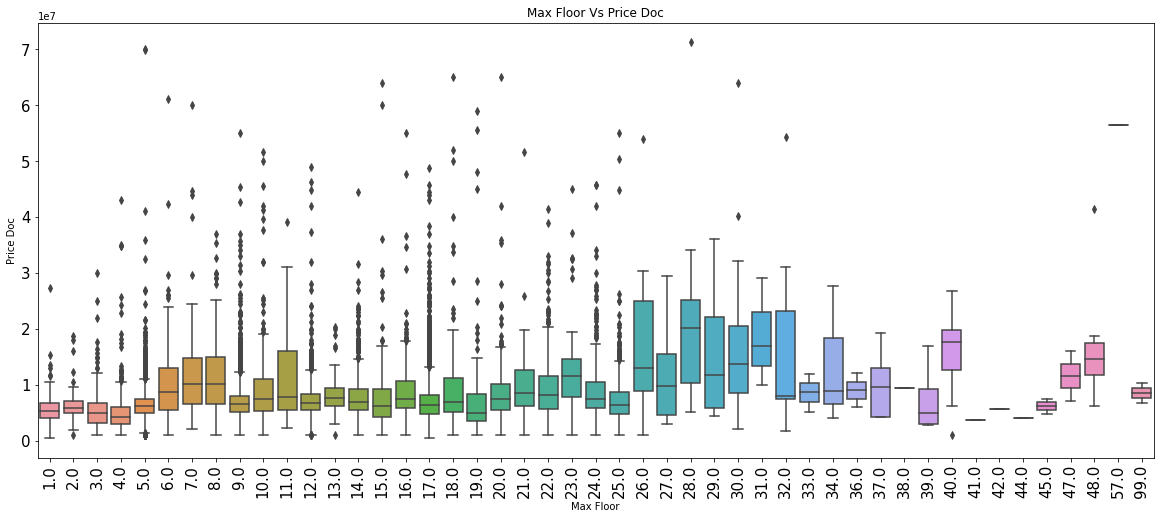

In [33]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='max_floor', y='price_doc', data=train, ax=ax)
plt.xticks(rotation=90, size =15)
plt.yticks(size =15)
ax.set(ylabel='Price Doc', xlabel='Max Floor', title='Max Floor Vs Price Doc')

[Text(0, 0.5, 'Price Doc'),
 Text(0.5, 0, 'Floor'),
 Text(0.5, 1.0, 'Floor Vs Price Doc')]

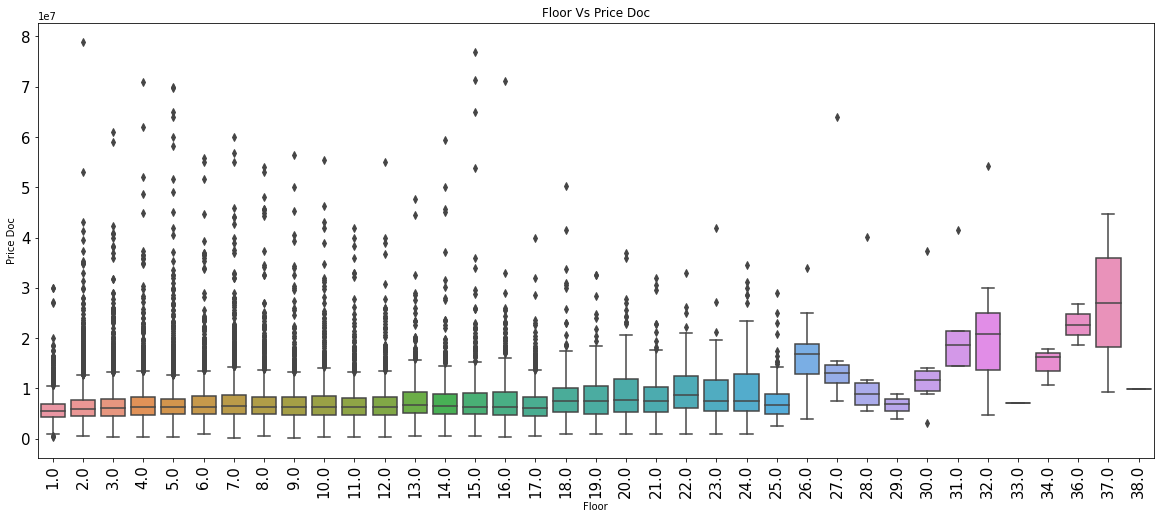

In [34]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
plt.xticks(rotation=90, size =15)
plt.yticks(size =15)
sns.boxplot(x='floor', y='price_doc', data=train, ax=ax)
ax.set(ylabel='Price Doc', xlabel='Floor', title='Floor Vs Price Doc')

Text(0.5, 1.0, 'Prix en fonction du nombre de salon')

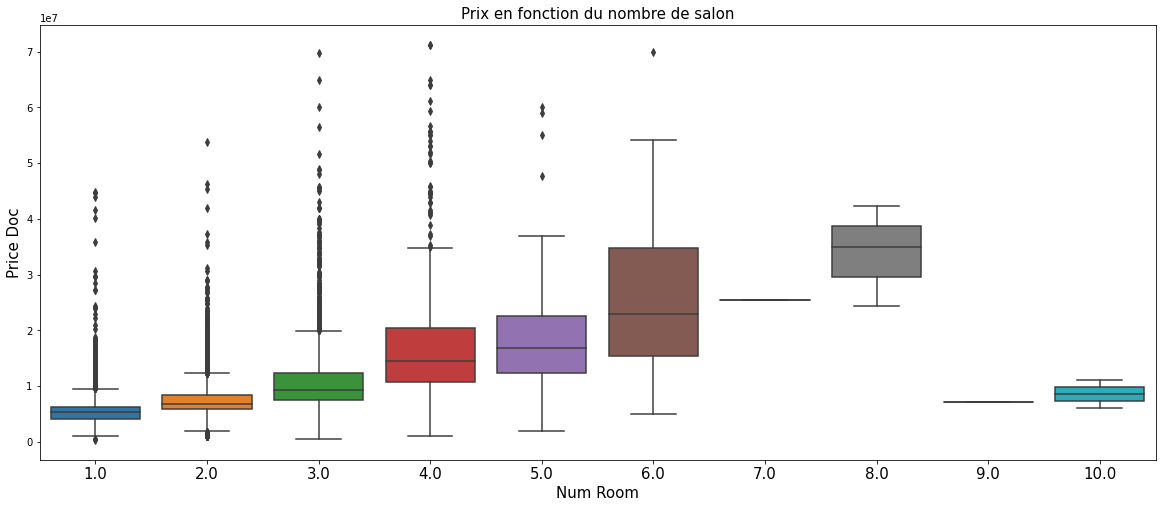

In [35]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='num_room', y='price_doc', data=train)
plt.xticks(size =15)
ax.set_xlabel('Num Room', fontsize = 15)
ax.set_ylabel('Price Doc', fontsize = 15)
ax.set_title('Prix en fonction du nombre de salon', fontsize = 15)

Text(0.5, 1.0, "Prix en fonction de l'état")

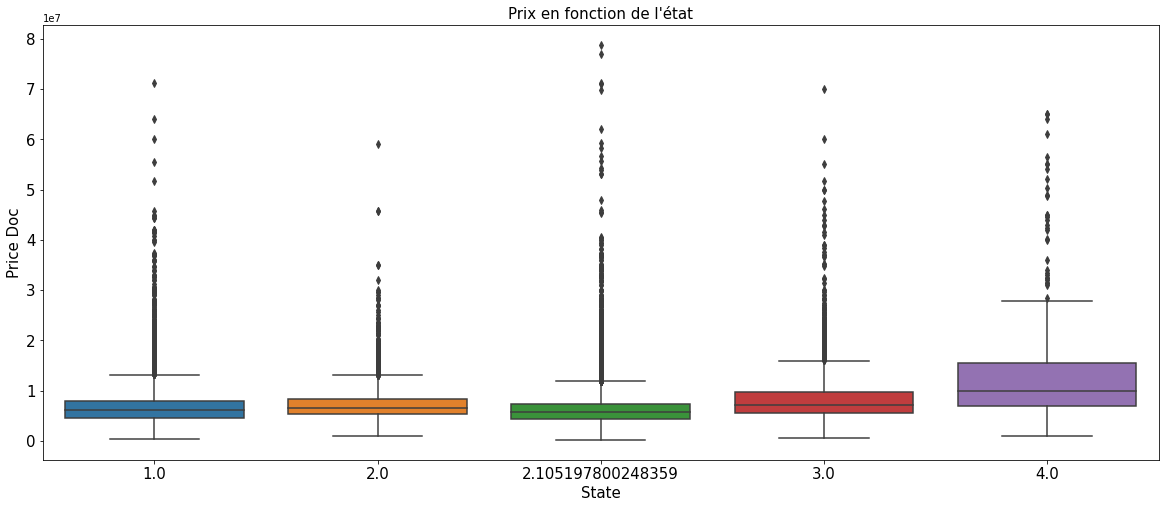

In [36]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='state', y='price_doc', data=train)
plt.xticks(size =15)
plt.yticks(size =15)
ax.set_xlabel('State', fontsize = 15)
ax.set_ylabel('Price Doc', fontsize = 15)
ax.set_title("Prix en fonction de l'état", fontsize = 15)

Text(0.5, 1.0, 'Prix en fonction du matériau mural')

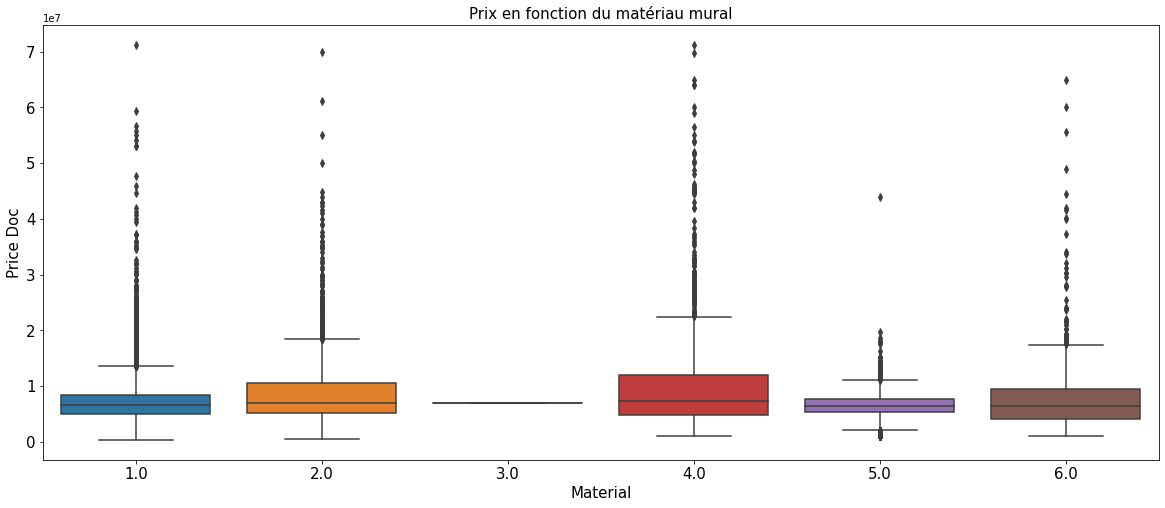

In [37]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='material', y='price_doc', data=train)
plt.xticks(size =15)
plt.yticks(size =15)
ax.set_xlabel('Material', fontsize = 15)
ax.set_ylabel('Price Doc', fontsize = 15)
ax.set_title("Prix en fonction du matériau mural", fontsize = 15)

Text(0.5, 1.0, 'Prix en fonction du type de bien')

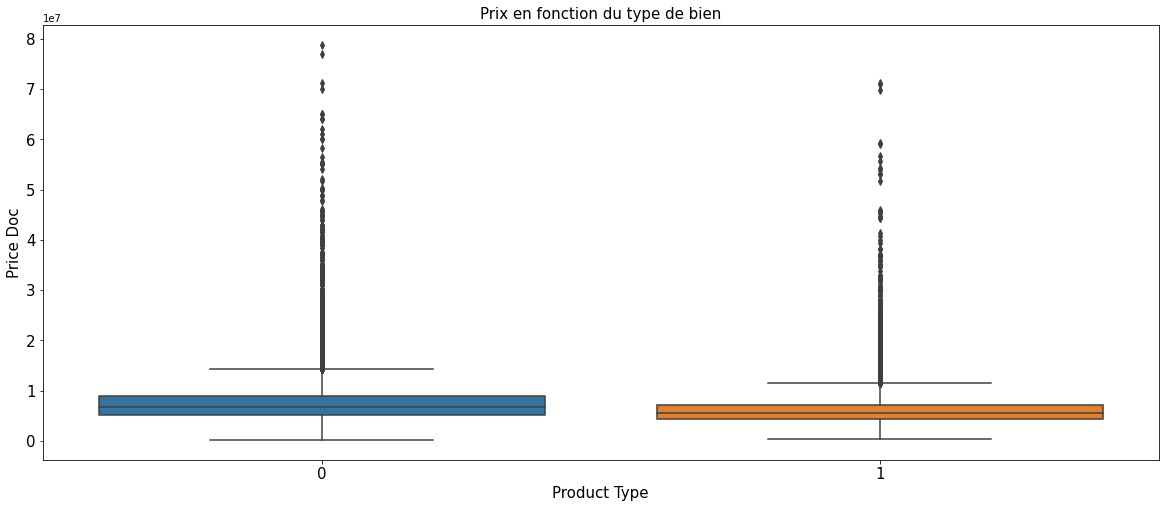

In [38]:
fig,ax= plt.subplots()
fig.set_size_inches(20,8)
sns.boxplot(x='product_type', y='price_doc', data=train)
plt.xticks(size =15)
plt.yticks(size =15)
ax.set_xlabel('Product Type', fontsize = 15)
ax.set_ylabel('Price Doc', fontsize = 15)
ax.set_title("Prix en fonction du type de bien", fontsize = 15)

In [39]:
kf = KFold(5, shuffle=True, random_state=1)
def rmse(modele) :
    mse = cross_val_score(modele, X, y, cv=kf,scoring=make_scorer(mean_squared_error)).mean()
    return pow(mse,0.5)

In [40]:
best_features = best_features[:6]

# Pour chaque colonne de best_features, on prédit les valeurs manquantes initialement.
for i_col in range(len(best_features)) :
    X = train_test.drop(best_features[i_col],axis=1).loc[idx_not_nan_train_test_best_features[i_col]]
    y = train_test[best_features[i_col]].loc[idx_not_nan_train_test_best_features[i_col]]
        
    LGBmodel = LGBMRegressor(n_jobs=-1)
    LGBmodel.fit(X,y)

    x_test = train.drop(best_features[i_col],axis=1).loc[idx_nan_train_best_features[i_col]]
    predictions = LGBmodel.predict(x_test)
    train.loc[idx_nan_train_best_features[i_col],best_features[i_col]] = predictions

In [41]:
train = train.fillna(train.mean())
test = test.fillna(test.mean())

In [42]:
X=train.drop('price_doc',axis=1)
y=train['price_doc']

In [43]:
# On utilise d'autres paramètres que ceux calculés par SearchCV qui donnent un meilleur résultat
LGBmodel = LGBMRegressor(num_leaves=5, learning_rate=0.1, max_depth=5, n_estimators=200, seed=1)
LGBmodel.fit(X,y)
rmse(LGBmodel)

2643123.663167183

In [44]:
# on crée un nouveau dataset auquel on ajoute les id et les valeurs des prix prédits
res=pd.DataFrame()
res["id"]=test["id"]
# res["price_doc"]=CatModel.predict(test)
# res["price_doc"]= bagVotingBagModel.predict(test)
res["price_doc"]=LGBmodel.predict(test)
# on enregistre les prédictions dans le fichier csv
res.to_csv('pred.csv',index=False)

In [45]:
# 0.31896 LGBmodel
# 0.31638 CatModel
# 0.31486 BagVotingBagModel
# 0.30087 best kaggle score